In [1]:
from torchvision import transforms
from torch.autograd import Variable
from timeit import default_timer as timer

import os
import cv2
import torch.utils.data as data
import pandas as pd
import random
import numpy as np
import torch.nn.functional as F
import torch
import torchvision.models as models
import pickle
import torch.nn as nn
import math
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print(f'Using GPU : {torch.cuda.get_device_name(0)}')
else:
    device = torch.device("cpu")
    gpu = 0 
    print(f'Using CPU')

Using GPU : Tesla P100-PCIE-16GB


In [3]:
workers = 2 # number of workers
batch_size = 32 # batch size
w = 7 # width of attention map
h = 7 # height of attention map
gpu = 1 # gpu devices
lam = 5 # kl_lambda param
epochs = 100 # epochs

In [4]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
def add_g(image_array, mean=0.0, var=30):
    std = var ** 0.5
    image_add = image_array + np.random.normal(mean, std, image_array.shape)
    image_add = np.clip(image_add, 0, 255).astype(np.uint8)
    return image_add

def flip_image(image_array):
    return cv2.flip(image_array, 1)
    
def generate_flip_grid(w, h, device):
    # used to flip attention maps
    x_ = torch.arange(w).view(1, -1).expand(h, -1)
    y_ = torch.arange(h).view(-1, 1).expand(-1, w)
    grid = torch.stack([x_, y_], dim=0).float().to(device)
    grid = grid.unsqueeze(0).expand(1, -1, -1, -1)
    grid[:, 0, :, :] = 2 * grid[:, 0, :, :] / (w - 1) - 1
    grid[:, 1, :, :] = 2 * grid[:, 1, :, :] / (h - 1) - 1
    grid[:, 0, :, :] = -grid[:, 0, :, :]
    return grid

In [6]:
class RafDataset(data.Dataset):
    def __init__(self, df, directory, phase, basic_aug=True, transform=None):
        self.phase = phase
        self.basic_aug = basic_aug
        self.transform = transform
        self.directory = directory
        self.aug_func = [flip_image, add_g]
        self.file_paths = df.image.values
        self.labels = df.emotion.values - 1
        
        del df
        

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image_name = self.file_paths[idx][:-4] + "_aligned.jpg"
        full_path = os.path.join(self.directory, image_name)
        image = cv2.imread(full_path)
            
        image = image[:, :, ::-1]
        
        image1 = image
        image1 = self.aug_func[0](image)
        image1 = self.transform(image1)

        if self.phase == 'train':
            if self.basic_aug and random.uniform(0, 1) > 0.5:
                image = self.aug_func[1](image)

        if self.transform is not None:
            image = self.transform(image)
        
        image1 = transforms.RandomHorizontalFlip(p=1)(image)

        return image, label, idx, image1

In [7]:
def ACLoss(att_map1, att_map2, grid_l, output):
    flip_grid_large = grid_l.expand(output.size(0), -1, -1, -1)
    flip_grid_large = Variable(flip_grid_large, requires_grad = False)
    flip_grid_large = flip_grid_large.permute(0, 2, 3, 1)
    att_map2_flip = F.grid_sample(att_map2, flip_grid_large, mode = 'bilinear', padding_mode = 'border', align_corners=True)
    flip_loss_l = F.mse_loss(att_map1, att_map2_flip)
    return flip_loss_l

In [8]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [9]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

In [10]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=8631, include_top=True):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.include_top = include_top
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        
        if not self.include_top:
            return x
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [11]:
class Model(nn.Module):
    
    def __init__(self, resnet50_path, pretrained=True, num_classes=7):
        super(Model, self).__init__()
        resnet50 = ResNet(Bottleneck, [3, 4, 6, 3])
        with open(resnet50_path, 'rb') as f:
            obj = f.read()
        weights = {key: torch.from_numpy(arr) for key, arr in pickle.loads(obj, encoding='latin1').items()}
        resnet50.load_state_dict(weights)
        
        self.features = nn.Sequential(*list(resnet50.children())[:-2])  
        self.features2 = nn.Sequential(*list(resnet50.children())[-2:-1])  
        self.fc = nn.Linear(2048, 7)  
        
        
    def forward(self, x):        
        x = self.features(x)
        #### 1, 2048, 7, 7
        feature = self.features2(x)
        #### 1, 2048, 1, 1
        
        feature = feature.view(feature.size(0), -1)
        output = self.fc(feature)
        
        params = list(self.parameters())
        fc_weights = params[-2].data
        fc_weights = fc_weights.view(1, 7, 2048, 1, 1)
        fc_weights = Variable(fc_weights, requires_grad = False)

        # attention
        feat = x.unsqueeze(1) # N * 1 * C * H * W
        hm = feat * fc_weights
        hm = hm.sum(2) # N * self.num_labels * H * W

        return output, hm

In [12]:
def train(model, train_loader, optimizer, scheduler, device):
    running_loss = 0.0
    iter_cnt = 0
    correct_sum = 0
    
    model.to(device)
    model.train()

    total_loss = []
    for batch_i, (imgs1, labels, indexes, imgs2) in enumerate(train_loader):
        imgs1 = imgs1.to(device)
        imgs2 = imgs2.to(device)
        labels = labels.to(device)


        criterion = nn.CrossEntropyLoss(reduction='none')



        output, hm1 = model(imgs1)
        output_flip, hm2 = model(imgs2)
        
        grid_l = generate_flip_grid(w, h, device)
        

        loss1 = nn.CrossEntropyLoss()(output, labels)
        flip_loss_l = ACLoss(hm1, hm2, grid_l, output)


        loss = loss1 + lam * flip_loss_l


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        iter_cnt += 1
        _, predicts = torch.max(output, 1)
        correct_num = torch.eq(predicts, labels).sum()
        correct_sum += correct_num
        running_loss += loss

    scheduler.step()
    running_loss = running_loss / iter_cnt
    acc = correct_sum.float() / float(train_loader.dataset.__len__())
    return acc, running_loss

In [13]:
def test(model, test_loader, device):
    with torch.no_grad():
        model.eval()

        running_loss = 0.0
        iter_cnt = 0
        correct_sum = 0
        data_num = 0


        for batch_i, (imgs1, labels, indexes, imgs2) in enumerate(test_loader):
            imgs1 = imgs1.to(device)
            labels = labels.to(device)


            outputs, _ = model(imgs1)


            loss = nn.CrossEntropyLoss()(outputs, labels)

            iter_cnt += 1
            _, predicts = torch.max(outputs, 1)

            correct_num = torch.eq(predicts, labels).sum()
            correct_sum += correct_num

            running_loss += loss
            data_num += outputs.size(0)

        running_loss = running_loss / iter_cnt
        test_acc = correct_sum.float() / float(data_num)
    return test_acc, running_loss

In [14]:
train_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(scale=(0.02, 0.25)) ])
    
eval_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

In [15]:
path_to_labels = '/kaggle/input/eacdata/raf-basic/EmoLabel/list_patition_label.txt'
path_to_images = '/kaggle/input/raf-db-aligned-data/aligned'

In [16]:
raf_db_data = pd.read_csv(path_to_labels, sep=" ", header=None)
raf_db_data.rename(columns={0 : 'image', 1 : 'emotion'}, inplace=True)
print(raf_db_data.shape)
raf_db_data.head()

(15339, 2)


,image,emotion
0,train_00001.jpg,5
1,train_00002.jpg,5
2,train_00003.jpg,4
3,train_00004.jpg,4
4,train_00005.jpg,5


In [17]:
train_data = raf_db_data[raf_db_data.image.str.contains('train')]
test_data = raf_db_data[raf_db_data.image.str.contains('test')]

del raf_db_data

Train : 12271
Test : 3068
Sample : (tensor([[[ 1.3584,  1.2899,  1.1358,  ...,  0.5707,  0.5707,  0.5707],
         [ 1.4098,  1.3584,  1.2557,  ...,  0.5878,  0.5878,  0.5878],
         [ 1.5639,  1.5468,  1.5639,  ...,  0.6049,  0.6049,  0.6049],
         ...,
         [-0.1657, -0.1657, -0.1828,  ..., -0.6109, -0.5767, -0.5596],
         [-0.1828, -0.1828, -0.1999,  ..., -0.6281, -0.5938, -0.5767],
         [-0.1828, -0.1828, -0.1999,  ..., -0.6281, -0.5938, -0.5767]],

        [[-0.1975, -0.2500, -0.4076,  ...,  0.0126,  0.0126,  0.0126],
         [-0.1275, -0.1800, -0.2850,  ...,  0.0301,  0.0301,  0.0301],
         [ 0.0301,  0.0301,  0.0476,  ...,  0.0476,  0.0476,  0.0476],
         ...,
         [-0.9328, -0.9328, -0.9503,  ..., -1.3880, -1.3529, -1.3354],
         [-0.9503, -0.9503, -0.9678,  ..., -1.4055, -1.3704, -1.3529],
         [-0.9503, -0.9503, -0.9678,  ..., -1.4055, -1.3704, -1.3529]],

        [[-0.6193, -0.6715, -0.8284,  ..., -1.2816, -1.2816, -1.2816],
         

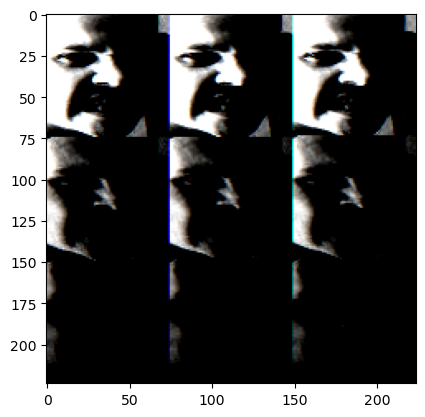

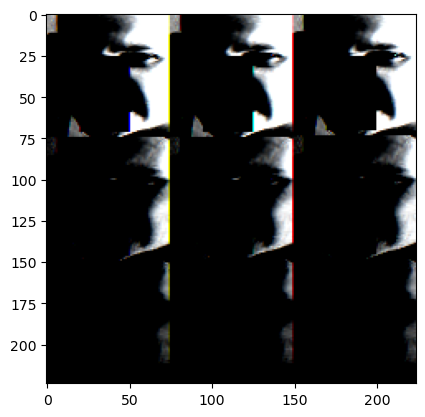

In [18]:
train_dataset = RafDataset(train_data, path_to_images, phase='train', transform=train_transforms)
test_dataset = RafDataset(test_data, path_to_images, phase='test', transform=eval_transforms)

print(f'Train : {len(train_dataset)}')
print(f'Test : {len(test_dataset)}')
print(f'Sample : {train_dataset[1000]}')
plt.imshow(train_dataset[1000][0].numpy().reshape(224, 224, 3))
plt.show()
plt.imshow(train_dataset[1000][3].numpy().reshape(224,224,3))

In [19]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=workers,
                                           pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=workers,
                                          pin_memory=True)

print(f'Num of batches train : {len(train_loader)}')
print(f'Num of batches test : {len(test_loader)}')

Num of batches train : 384
Num of batches test : 96


In [20]:
resnet_50_path = '/kaggle/input/eacdata/resnet50_ft_weight.pkl'

In [21]:
model = Model(resnet_50_path)
model.to(device)

Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 25

In [22]:
optimizer = torch.optim.Adam(model.parameters() , lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [23]:
def trainer(epochs, output_path='/kaggle/working/'):
    best_test_acc = 0
    last_best = 0
    k = 10
    print('#------Started training------#')
    for i in range(1, epochs + 1):
        
        start_train = timer()
        train_acc, train_loss = train(model, train_loader, optimizer, scheduler, device)
        end_train = timer()
        
        start_test = timer()
        test_acc, test_loss = test(model, test_loader, device)
        end_test = timer()
        
        print(f'Epoch {i}/{epochs}')
        print(f'Train Acc : {train_acc}, train_loss : {train_loss}')
        print(f'Test Acc : {test_acc}, test_loss : {test_loss}')
        print(f'Train time : {end_train - start_train}, test time : {end_test - start_test}')
        print('#---------------------#')
        if not os.path.isdir(output_path):
            os.makedirs(output_path)
            
        if test_acc > best_test_acc:
            if i >= k:
                torch.save({'iter': i,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(), },
                        os.path.join(output_path, "epoch" + str(i) + "_acc %f"%(test_acc) + ".pth"))
            last_best = i
            
        best_test_acc = max(best_test_acc, test_acc)
        
        if i - last_best > k:
            print(f'Converged by last {k} epochs')
        
    print('#-----Finished training-----#')
    print(f'Best test accuracy : {best_test_acc}')

In [24]:
setup_seed(0)

trainer(epochs)

#------Started training------#
Epoch 1/100
Train Acc : 0.6748431324958801, train_loss : 1.4763433933258057
Test Acc : 0.8005214929580688, test_loss : 0.597632884979248
Train time : 150.35897522100004, test time : 19.59336139000004
#---------------------#
Epoch 2/100
Train Acc : 0.7974085211753845, train_loss : 0.7675418257713318
Test Acc : 0.8269230723381042, test_loss : 0.5176064968109131
Train time : 143.986544159, test time : 13.994563907000042
#---------------------#
Epoch 3/100
Train Acc : 0.8242197036743164, train_loss : 0.6680567264556885
Test Acc : 0.849413275718689, test_loss : 0.4661140441894531
Train time : 144.325547754, test time : 13.922779251000065
#---------------------#
Epoch 4/100
Train Acc : 0.8434520363807678, train_loss : 0.6131871938705444
Test Acc : 0.8510429859161377, test_loss : 0.45209258794784546
Train time : 144.03937365700017, test time : 15.42647164999994
#---------------------#
Epoch 5/100
Train Acc : 0.8597506284713745, train_loss : 0.5623842477798462
Te